Importando todo o necessário

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torchvision.transforms as transforms
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import random

Importando a base de dados

In [2]:
diretorio_treino = "C:\\Users\\Pichau\\Desktop\\Faculdade\\Projects\\Facul Repositorios\\Repositorios_Universitarios\\Redes Neurais\\Projetao\\dataset_treino" # caminho direto
diretorio_teste = "C:\\Users\\Pichau\\Desktop\\Faculdade\\Projects\\Facul Repositorios\\Repositorios_Universitarios\\Redes Neurais\\Projetao\\testset_simpsons"

# Transformações para aplicar às imagens
transformacoes = transforms.Compose([
    transforms.Resize((75, 75)),  # Ajustado para 75x75 pixels
    transforms.ToTensor(),
])

# Carregamento dos dados de treinamento e teste
dados_treino = ImageFolder(root=diretorio_treino, transform=transformacoes)
dados_teste = ImageFolder(root=diretorio_teste, transform=transformacoes)

# DataLoader para iterar sobre os dados
loader_treino = DataLoader(dados_treino, batch_size=32, shuffle=True)
loader_teste = DataLoader(dados_teste, batch_size=32, shuffle=False)

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes): # arquitetura sugerida
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 9 * 9, 512)
        self.fc2 = nn.Linear(512, num_classes) # num_classes que no caso desse projeto é 10

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(-1, 64 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

vgg16 = models.vgg16(pretrained=True).to(device)
resnet = models.resnet18(pretrained=True).to(device)
densenet = models.densenet121(pretrained=True).to(device)
mobilenet = models.mobilenet_v2(pretrained=True).to(device)
cnn = CNN(num_classes=len(dados_treino.classes)).to(device)

# Definindo otimizadores e critérios de perda
otimizador_vgg16 = optim.Adam(vgg16.parameters(), lr=0.001)
otimizador_resnet = optim.Adam(resnet.parameters(), lr=0.001)
otimizador_densenet = optim.Adam(densenet.parameters(), lr=0.001)
otimizador_mobilenet = optim.Adam(mobilenet.parameters(), lr=0.001)
otimizador_cnn = optim.Adam(cnn.parameters(), lr=0.001)

criterio = nn.CrossEntropyLoss()


In [4]:
# Função para calcular a acurácia
def calcular_acuracia(saidas, rotulos):
    _, previsoes = torch.max(saidas, 1)
    acertos = (previsoes == rotulos).sum().item()
    total = rotulos.size(0)
    return acertos / total

In [5]:
def treinar_modelo(modelo, otimizador, loader, criterio, num_epocas, nome_modelo):
    # Lista para armazenar as perdas e acurácias em cada época
    perdas = []
    acuracias = []

    # Loop de treinamento
    for epoch in range(num_epocas):
        modelo.train()  # Define o modelo em modo de treinamento
        running_loss = 0.0
        running_accuracy = 0.0

        # Itera sobre os dados de treinamento
        for imagens, rotulos in loader:
            otimizador.zero_grad()  # Zera os gradientes acumulados
            saidas = modelo(imagens)  # Obtém as saídas do modelo
            perda = criterio(saidas, rotulos)  # Calcula a perda
            perda.backward()  # Retropropagação
            otimizador.step()  # Atualiza os pesos
            running_loss += perda.item() * imagens.size(0)  # Acumula a perda
            running_accuracy += calcular_acuracia(saidas, rotulos) * imagens.size(0)  # Acumula a acurácia

        # Calcula a perda e acurácia média por época
        epoch_loss = running_loss / len(loader.dataset)
        epoch_accuracy = running_accuracy / len(loader.dataset)

        # Adiciona as métricas à lista
        perdas.append(epoch_loss)
        acuracias.append(epoch_accuracy)

        # Imprime informações de progresso
        print(f'Modelo: {nome_modelo}, Época {epoch+1}/{num_epocas}: Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

    # Retorna as listas de perdas e acurácias para análise posterior
    return perdas, acuracias


In [24]:
num_epocas = 2

In [113]:
perdas_mobilenet, acuracias_mobilenet = treinar_modelo(mobilenet, otimizador_mobilenet, loader_treino, criterio, num_epocas, "mobilenet")

Modelo: mobilenet, Época 1/5: Loss: 0.7342, Accuracy: 0.7812
Modelo: mobilenet, Época 2/5: Loss: 0.3224, Accuracy: 0.9005
Modelo: mobilenet, Época 3/5: Loss: 0.2605, Accuracy: 0.9222
Modelo: mobilenet, Época 4/5: Loss: 0.2331, Accuracy: 0.9295
Modelo: mobilenet, Época 5/5: Loss: 0.1957, Accuracy: 0.9411


In [16]:
perdas_cnn, acuracias_cnn = treinar_modelo(cnn, otimizador_cnn, loader_treino, criterio, num_epocas, "cnn")

Modelo: cnn, Época 1/10: Loss: 1.6522, Accuracy: 0.4997
Modelo: cnn, Época 2/10: Loss: 0.8373, Accuracy: 0.7486
Modelo: cnn, Época 3/10: Loss: 0.5141, Accuracy: 0.8435
Modelo: cnn, Época 4/10: Loss: 0.3159, Accuracy: 0.9012
Modelo: cnn, Época 5/10: Loss: 0.1941, Accuracy: 0.9376
Modelo: cnn, Época 6/10: Loss: 0.1305, Accuracy: 0.9569
Modelo: cnn, Época 7/10: Loss: 0.0992, Accuracy: 0.9680
Modelo: cnn, Época 8/10: Loss: 0.0930, Accuracy: 0.9695
Modelo: cnn, Época 9/10: Loss: 0.0792, Accuracy: 0.9752
Modelo: cnn, Época 10/10: Loss: 0.0723, Accuracy: 0.9774


In [ ]:
perdas_vgg16, acuracias_vgg16 = treinar_modelo(vgg16, otimizador_vgg16, loader_treino, criterio, num_epocas, "vgg16")

In [22]:
perdas_resnet, acuracias_resnet = treinar_modelo(resnet, otimizador_resnet, loader_treino, criterio, num_epocas, "resnet")

Modelo: resnet, Época 1/2: Loss: 0.8613, Accuracy: 0.7514
Modelo: resnet, Época 2/2: Loss: 0.4314, Accuracy: 0.8759


In [117]:
perdas_densenet, acuracias_densenet = treinar_modelo(densenet, otimizador_densenet, loader_treino, criterio, num_epocas, "densenet")

Modelo: densenet, Época 1/5: Loss: 0.7340, Accuracy: 0.7882
Modelo: densenet, Época 2/5: Loss: 0.3169, Accuracy: 0.9052
Modelo: densenet, Época 3/5: Loss: 0.2735, Accuracy: 0.9183
Modelo: densenet, Época 4/5: Loss: 0.2773, Accuracy: 0.9178
Modelo: densenet, Época 5/5: Loss: 0.1553, Accuracy: 0.9531


Avalia o modelo buscando overthinking nem undertraining

In [18]:
def avaliar_modelo(modelo, loader):
    modelo.eval()  # Define o modelo em modo de avaliação
    total = 0
    acertos = 0
    
    # Itera sobre os dados
    with torch.no_grad():
        for imagens, rotulos in loader:
            saidas = modelo(imagens)  # Obtém as saídas do modelo
            _, previsoes = torch.max(saidas, 1)  # Obtém as previsões
            total += rotulos.size(0)
            acertos += (previsoes == rotulos).sum().item()  # Calcula o número de previsões corretas
    
    # Calcula a acurácia
    acuracia = 100 * acertos / total
    return acuracia


# Agora você pode usar essa função para avaliar cada modelo nos conjuntos de treino e teste

acuracia_treino_resnet = avaliar_modelo(resnet, loader_treino)
acuracia_teste_resnet = avaliar_modelo(resnet, loader_teste)

acuracia_treino_densenet = avaliar_modelo(densenet, loader_treino)
acuracia_teste_densenet = avaliar_modelo(densenet, loader_teste)

acuracia_treino_cnn = avaliar_modelo(cnn, loader_treino)
acuracia_teste_cnn = avaliar_modelo(cnn, loader_teste)

#acuracia_treino_vgg16 = avaliar_modelo(vgg16, loader_treino)
#acuracia_teste_vgg16 = avaliar_modelo(vgg16, loader_teste)

In [19]:
acuracia_treino_mobilenet = avaliar_modelo(mobilenet, loader_treino)
acuracia_teste_mobilenet = avaliar_modelo(mobilenet, loader_teste)

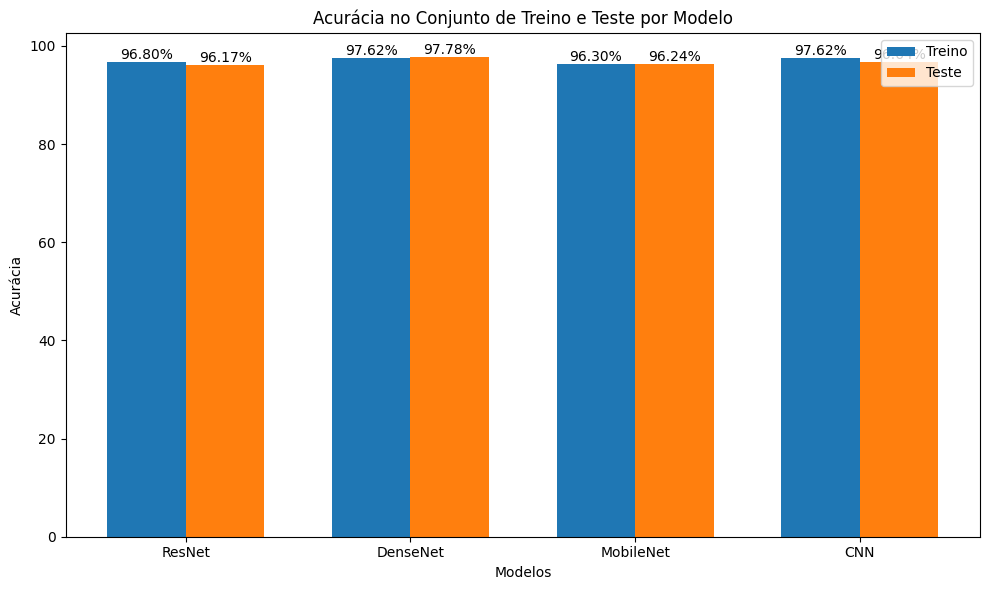

In [135]:
import numpy as np
import matplotlib.pyplot as plt

# Lista de modelos
modelos = ['ResNet', 'DenseNet', 'MobileNet', 'CNN']

# Lista de acurácias no conjunto de treino
acuracias_treino = [acuracia_treino_resnet, acuracia_treino_densenet, acuracia_treino_mobilenet, acuracia_treino_cnn]

# Lista de acurácias no conjunto de teste
acuracias_teste = [acuracia_teste_resnet, acuracia_teste_densenet, acuracia_teste_mobilenet, acuracia_teste_cnn]

# Definindo a largura das barras
largura_barra = 0.35

# Criando os índices para as barras
indices = np.arange(len(modelos))

# Criando gráfico de barras para comparar acurácias de treino e teste
plt.figure(figsize=(10, 6))
plt.bar(indices - largura_barra/2, acuracias_treino, width=largura_barra, label='Treino')
plt.bar(indices + largura_barra/2, acuracias_teste, width=largura_barra, label='Teste')

# Adicionando as porcentagens acima de cada barra
for i, treino, teste in zip(indices, acuracias_treino, acuracias_teste):
    plt.text(i - largura_barra/2, treino + 0.01, f'{treino:.2f}%', ha='center', va='bottom')
    plt.text(i + largura_barra/2, teste + 0.01, f'{teste:.2f}%', ha='center', va='bottom')

plt.xticks(indices, modelos)
plt.xlabel('Modelos')
plt.ylabel('Acurácia')
plt.title('Acurácia no Conjunto de Treino e Teste por Modelo')
plt.legend()
plt.tight_layout()
plt.show()


In [12]:
# Função para mostrar imagens com seus rótulos e previsões para um modelo específico
def mostrar_imagens_com_previsoes(loader, modelo, nome_modelo, num_imagens=5):
    classes = loader.dataset.classes
    fig, axs = plt.subplots(1, num_imagens, figsize=(15, 3))

    # Selecionando imagens aleatórias
    indices = random.sample(range(len(loader.dataset)), num_imagens)

    # Movendo o modelo para o modo de avaliação
    modelo.eval()

    with torch.no_grad():
        for i, idx in enumerate(indices):
            imagem, rotulo = loader.dataset[idx]
            imagem = imagem.unsqueeze(0).to(device)  # Adicionando dimensão de lote e movendo para GPU, se disponível
            rotulo_real = classes[rotulo]

            # Obtendo a previsão do modelo
            saida = modelo(imagem)
            _, previsao = torch.max(saida, 1)
            rotulo_previsto = classes[previsao.item()]

            # Plotando a imagem com rótulo real e previsão
            axs[i].imshow(imagem.squeeze().permute(1, 2, 0).cpu())  # Convertendo para o formato correto e movendo para a CPU
            axs[i].axis('off')
            axs[i].set_title(f'Real: {rotulo_real}\nPrevisto: {rotulo_previsto}', pad=20)  # Ajustando o espaçamento vertical

    # Adicionando título com o nome do modelo
    fig.suptitle(f'Modelo: {nome_modelo}', fontsize=14, y=1.1)  # Ajustando o espaçamento vertical

    plt.tight_layout()  # Ajusta automaticamente o layout para evitar sobreposição
    plt.show()


In [ ]:
# Chamando a função para mostrar as imagens para cada modelo treinado
mostrar_imagens_com_previsoes(loader_teste, resnet , 'ResNet')
mostrar_imagens_com_previsoes(loader_teste, densenet , 'DenseNet')
mostrar_imagens_com_previsoes(loader_teste, mobilenet , 'MobileNet')

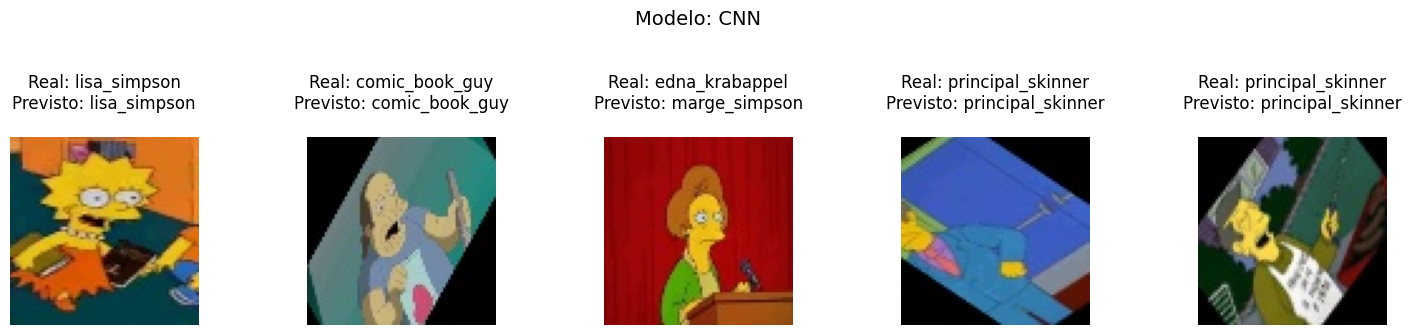

In [29]:
mostrar_imagens_com_previsoes(loader_teste, cnn , 'CNN')

In [127]:
# Função para plotar as perdas e acurácias
def plotar_metricas(perdas, acuracias, modelos):
    plt.figure(figsize=(12, 6))

    # Plotando as perdas
    plt.subplot(1, 2, 1)
    for i, modelo in enumerate(modelos):
        plt.plot(perdas[i], label=modelo)
    plt.title('Perdas durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Perda')
    plt.legend()

    # Plotando as acurácias
    plt.subplot(1, 2, 2)
    for i, modelo in enumerate(modelos):
        plt.plot(acuracias[i], label=modelo)
    plt.title('Acurácias durante o treinamento')
    plt.xlabel('Época')
    plt.ylabel('Acurácia')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [131]:
perdas_vgg16 = [2.3728, 2.2892, 2.2861] # CARREGANDO AS INFORMAÇOES QUE FORAM PERDIDAS DA VGG16
acuracias_vgg16 = [0.1494, 0.1607, 0.1620]

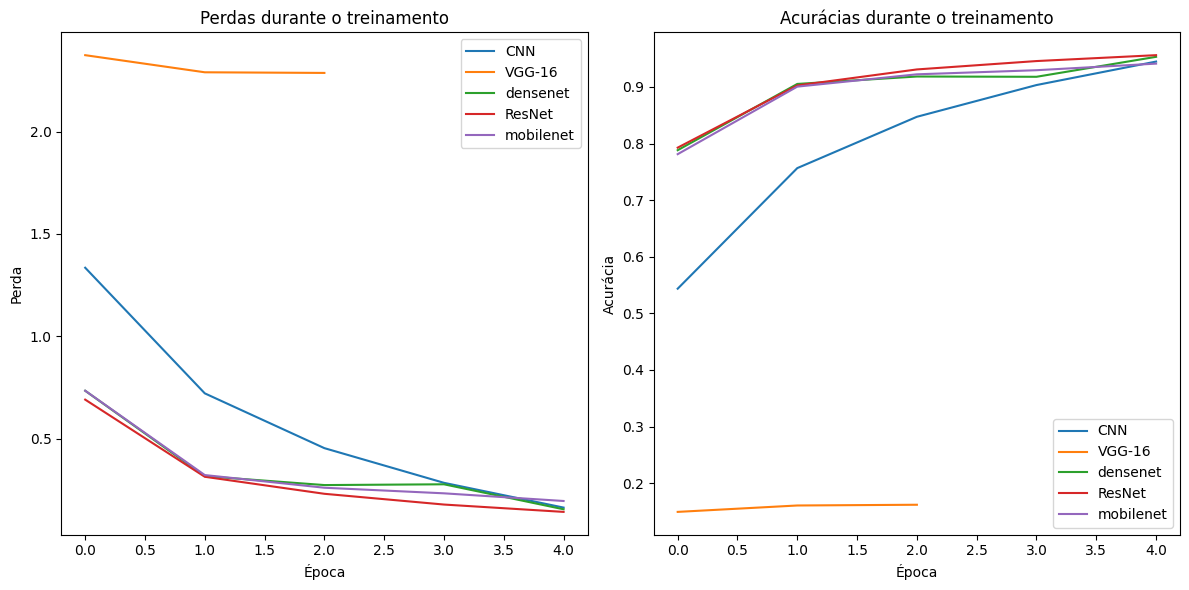

In [133]:
modelos = ["CNN", "VGG-16", "densenet", "ResNet", "mobilenet"]

# Listas de perdas e acurácias na mesma ordem
perdas = [perdas_cnn, perdas_vgg16, perdas_densenet, perdas_resnet, perdas_mobilenet]
acuracias = [acuracias_cnn, acuracias_vgg16, acuracias_densenet, acuracias_resnet, acuracias_mobilenet]

plotar_metricas(perdas, acuracias, modelos)

In [142]:
import os

# Verificar se o diretório 'redes' existe e criar se não existir
diretorio = 'redes'
if not os.path.exists(diretorio):
    os.makedirs(diretorio)

# Salvando os modelos
torch.save(vgg16.state_dict(), os.path.join(diretorio, 'vgg16.pth'))
torch.save(resnet.state_dict(), os.path.join(diretorio, 'resnet.pth'))
torch.save(densenet.state_dict(), os.path.join(diretorio, 'densenet.pth'))
torch.save(mobilenet.state_dict(), os.path.join(diretorio, 'mobilenet.pth'))
torch.save(cnn.state_dict(), os.path.join(diretorio, 'cnn.pth'))


In [143]:
# Carregando os modelos
vgg16 = models.vgg16(pretrained=False).to(device)
vgg16.load_state_dict(torch.load('redes/vgg16.pth'))

resnet = models.resnet18(pretrained=False).to(device)
resnet.load_state_dict(torch.load('redes/resnet.pth'))

densenet = models.densenet121(pretrained=False).to(device)
densenet.load_state_dict(torch.load('redes/densenet.pth'))

mobilenet = models.mobilenet_v2(pretrained=False).to(device)
mobilenet.load_state_dict(torch.load('redes/mobilenet.pth'))

cnn = CNN(num_classes=len(dados_treino.classes)).to(device)
cnn.load_state_dict(torch.load('redes/cnn.pth'))


c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Pichau\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


<All keys matched successfully>